# ACE Exploration

ACE (Advanced Composition Explorer) is equipped with nine scientific instruments to make comprehensive and coordinated in situ measurements. These instruments are categorized into two groups: High Resolution Spectrometers and Monitoring Instruments.

## High Resolution Spectrometers
- **CRIS** - Cosmic Ray Isotope Spectrometer
- **SIS** - Solar Isotope Spectrometer
- **ULEIS** - Ultra Low Energy Isotope Spectrometer
- **SEPICA** - Solar Energetic Particle Ionic Charge Analyzer
- **SWICS** - Solar Wind Ion Composition Spectrometer
- **SWIMS** - Solar Wind Ion Mass Spectrometer

## Monitoring Instruments
- **MAG** - Magnetic Field Monitor
- **SWEPAM** - Solar Wind Electron, Proton and Alpha Monitor
- **EPAM** - Electron, Proton and Alpha Monitor
- **SWICS** - Solar Wind Ion Composition Spectrometer

All open-source ACE data are formatted using hierarchical data format (HDF). The data are organized by instrument and by time-averaging periods. Each instrument's data are stored in separate HDF data files, and separate HDF files also contain the data from the different averaging periods. For most of the instruments, the data are averaged hourly, daily, and per 27 days (1 Bartels rotation).

## About Hierarchical Data Formats
Hierarchical Data Formats (HDF) are open source file formats that support large, complex, heterogeneous data. HDF files use a “file directory” like structure that allows you to organize data within the file in many different structured ways, as you might do with files on your computer. HDF files also allow for embedding of metadata making them self-describing.

---

## Analytical Questions
How can we apply novel dimension reduction methods, such as PCA, TSNE, etc., to obtain informative solar wind in-situ data representation in low-dimensional space? How can this low-dimensional representation provide better 2D/3D visualization support than traditional dimension reduction techniques?

## Libraries and global variables

In [1]:
# Standard library imports
import sys

# Third-party imports
from contextlib import suppress
import warnings

# Local application imports
sys.path.append("../src/scripts")
from utilities import (
    parse_hdf_data,
    flag_occurrences,
    visualize_flag,
    add_datetime_column,
)

# Set the warning filter to ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# global variables
MISSING_FLAG = -999.900

## Data Import

In [3]:
# read data
data_dir = "../data/ace/raw"
mag_df = parse_hdf_data(f"{data_dir}/MAG_data_1hr.txt")
swepam_df = parse_hdf_data(f"{data_dir}/SWEPAM_data_1hr.txt")
epam_df = parse_hdf_data(f"{data_dir}/EPAM_data_1hr.txt")
swics_df = parse_hdf_data(f"{data_dir}/SWICS_data_1day.txt")

ACE_DATASETS = [mag_df, swepam_df, epam_df, swics_df]
ACE_DATASETS_NAMES = ["MAG", "SWEPAM", "EPAM", "SWICS"]

In [4]:
# dtype conversion
for df in ACE_DATASETS:
    df[["year", "day", "hr", "min", "sec"]] = df[
        ["year", "day", "hr", "min", "sec"]
    ].astype(int)

    with suppress(KeyError):
        df['Quality'] = df['Quality'].astype(str)

In [5]:
# datetime conversion and drop redundant features
for df in ACE_DATASETS:
    add_datetime_column(df).drop(
        columns=["year", "day", "hr", "min", "sec", "fp_year", "fp_doy"],
        inplace=True,
        axis=1,
    )

## Data Cleaning

### Retain *Good* Quality data

Good data is flagged by the researchers with a value of 0. 

In [6]:
for df in ACE_DATASETS:
    with suppress(KeyError):
        df = df[df['Quality'] == 0]
        df.drop(columns='Quality', inplace=True)

### Handling Missing Values

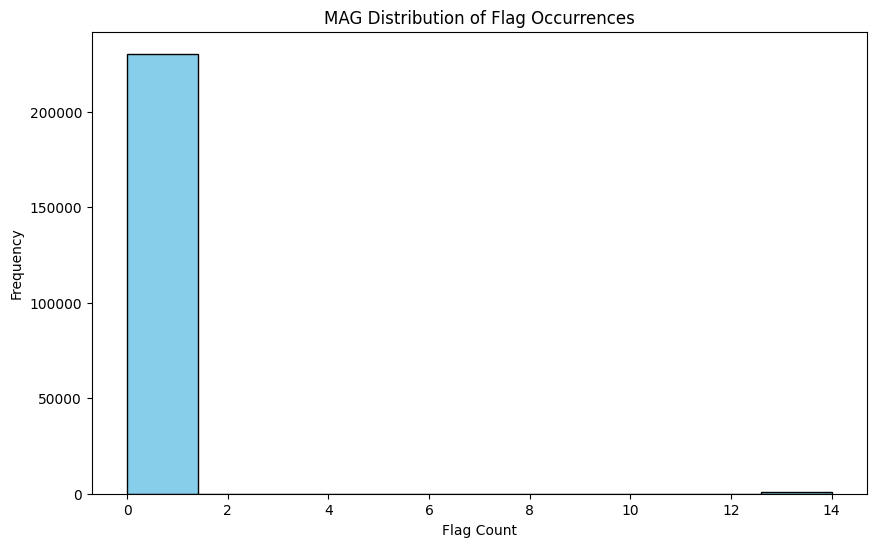

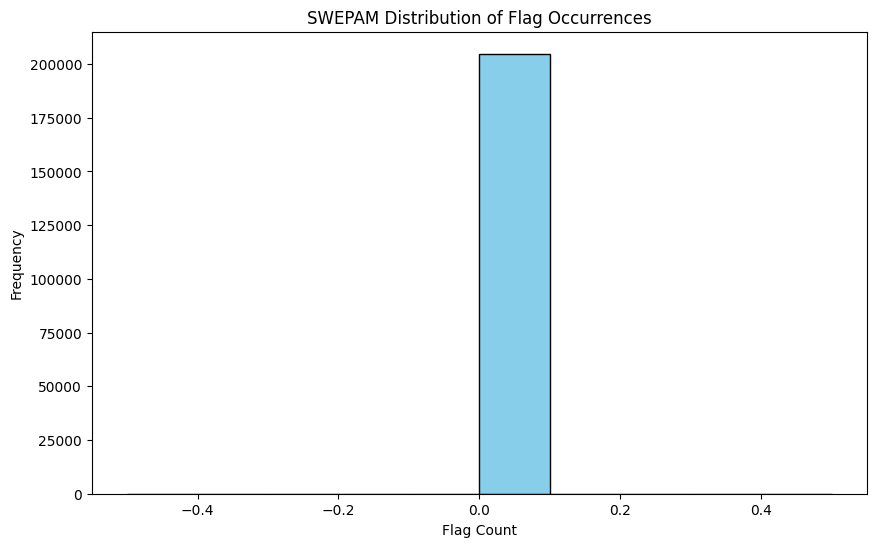

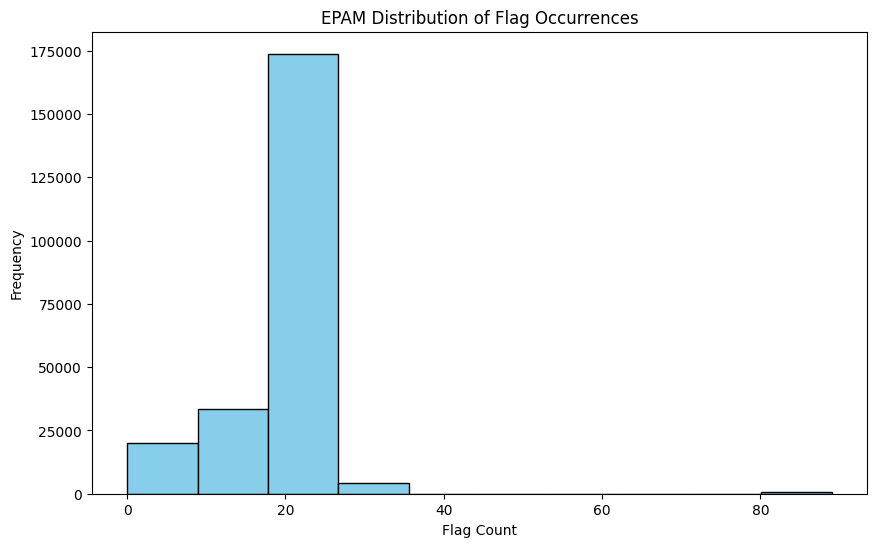

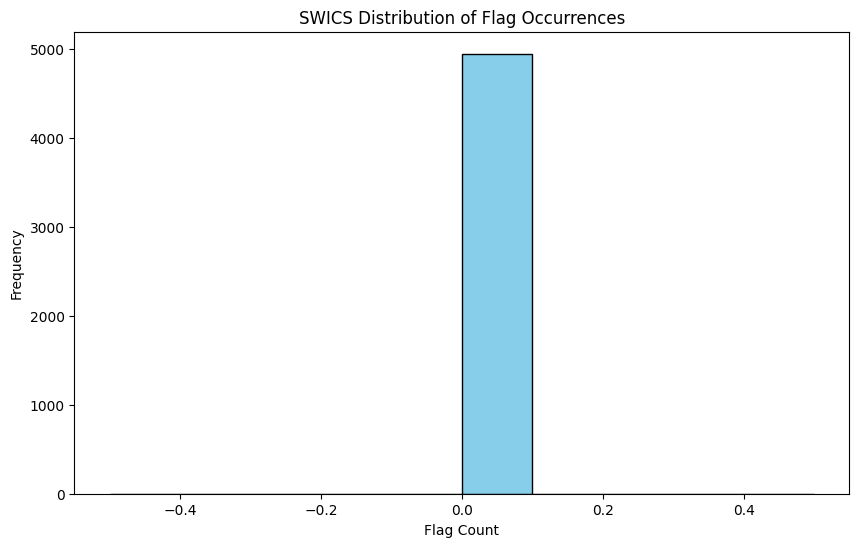

In [8]:
for df,df_name in zip(ACE_DATASETS,ACE_DATASETS_NAMES):
    missing_rows = df[df.eq("-999.900").any(axis=1)]
    flag_occurrences(df, MISSING_FLAG).sort_values(
        ascending=False, by="Flag_Count"
    )
    visualize_flag(df,df_name)

## Exploratory Data Analysis

### Descriptives

In [16]:
for df,df_name in zip(ACE_DATASETS,ACE_DATASETS_NAMES):
    print(f"Dataframe: {df_name}")
    display(df.info())
    display(df.describe())
    print("\n"+('-'*20))

Dataframe: MAG
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231336 entries, 0 to 231335
Data columns (total 28 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         231336 non-null  datetime64[ns]
 1   ACEepoch         231336 non-null  float64       
 2   SCclock          231336 non-null  float64       
 3   Br               231336 non-null  float64       
 4   Bt               231336 non-null  float64       
 5   Bn               231336 non-null  float64       
 6   Bmag             231336 non-null  float64       
 7   Delta            231336 non-null  float64       
 8   Lambda           231336 non-null  float64       
 9   Bgse_x           231336 non-null  float64       
 10  Bgse_y           231336 non-null  float64       
 11  Bgse_z           231336 non-null  float64       
 12  Bgsm_x           231336 non-null  float64       
 13  Bgsm_y           231336 non-null  float64       
 14  Bgsm_

None

,ACEepoch,SCclock,Br,Bt,Bn,Bmag,Delta,Lambda,Bgse_x,Bgse_y,...,fraction_good,N_vectors,pos_gse_x,pos_gse_y,pos_gse_z,pos_gsm_x,pos_gsm_y,pos_gsm_z,Flag_Count,Flag_Proportion
count,2.313360e+05,2.313360e+05,231336.000000,231336.000000,231336.000000,231336.000000,231336.000000,231336.000000,231336.000000,231336.000000,...,231336.000000,231336.000000,2.313360e+05,231336.000000,231336.000000,2.313360e+05,231336.000000,231336.000000,231336.000000,231336.000000
mean,4.674654e+08,4.205955e+08,-3.871007,-3.808264,-3.784931,1.979197,-3.869750,196.062699,-3.718902,-3.781131,...,0.995905,224.077368,1.482788e+06,-2437.617370,1683.444487,1.482804e+06,-1896.171801,4651.744091,0.053118,0.002125
std,2.404119e+08,2.752799e+08,61.575025,61.605103,61.550178,61.915690,67.842521,124.230072,61.584400,61.606392,...,0.062182,13.990851,6.929838e+04,182760.507192,106453.364131,6.932010e+04,176318.105686,116696.835180,0.860593,0.034424
min,5.106240e+07,6.970000e+02,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,...,0.000000,0.000000,3.442000e+04,-475680.000000,-165980.000000,3.442000e+04,-463990.000000,-265270.000000,0.000000,0.000000
25%,2.592639e+08,2.082025e+08,-2.659000,-2.532250,-1.317000,3.877750,-18.268250,122.090750,-2.522000,-2.513000,...,1.000000,225.000000,1.432400e+06,-182880.000000,-104232.500000,1.432400e+06,-169330.000000,-88805.000000,0.000000,0.000000
50%,4.674654e+08,4.164044e+08,-0.141500,0.010000,0.005000,5.077000,0.082000,178.055500,0.099000,-0.052000,...,1.000000,225.000000,1.480800e+06,-2113.150000,3099.200000,1.480800e+06,-2782.250000,10900.000000,0.000000,0.000000
75%,6.756669e+08,6.246062e+08,2.484000,2.481000,1.306000,6.851000,17.900000,300.733500,2.624000,2.484000,...,1.000000,225.000000,1.538900e+06,179700.000000,107750.000000,1.538900e+06,166180.000000,107210.000000,0.000000,0.000000
max,8.838684e+08,4.294967e+09,41.120000,35.083000,36.638000,71.993000,89.107000,359.998000,33.287000,45.473000,...,1.000000,226.000000,1.594800e+06,268000.000000,164090.000000,1.594800e+06,298140.000000,308840.000000,14.000000,0.560000



--------------------
Dataframe: SWEPAM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204768 entries, 0 to 204767
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   datetime                      204768 non-null  datetime64[ns]
 1   ACEepoch                      204768 non-null  float64       
 2   proton_density                204768 non-null  float64       
 3   proton_temp                   204768 non-null  float64       
 4   He4toprotons                  204768 non-null  float64       
 5   proton_speed                  204768 non-null  float64       
 6   x_dot_GSE                     204768 non-null  float64       
 7   y_dot_GSE                     204768 non-null  float64       
 8   z_dot_GSE                     204768 non-null  float64       
 9   x_dot_RTN                     204768 non-null  float64       
 10  y_dot_RTN                     204768 non

None

,ACEepoch,proton_density,proton_temp,He4toprotons,proton_speed,x_dot_GSE,y_dot_GSE,z_dot_GSE,x_dot_RTN,y_dot_RTN,...,fraction_time_proton_density,fraction_time_proton_temp,fraction_time_He4toprotons,fraction_time_proton_speed,fraction_time_dot_GSE,fraction_time_dot_RTN,fraction_time_Electron_temp,weight,Flag_Count,Flag_Proportion
count,2.047680e+05,204768.000000,2.047680e+05,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,...,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.000000,204768.0,204768.000000,204768.0,204768.0
mean,4.336398e+08,-3583.192620,7.729277e+04,-4039.195095,284.306873,-561.650643,-140.401359,-144.888509,280.170499,-141.045238,...,0.580415,0.799835,0.518758,0.931895,0.930986,0.930986,0.0,32.649042,0.0,0.0
std,2.128017e+08,4798.960802,7.644430e+04,4906.807287,1221.741970,1132.031778,1178.295150,1177.696664,1232.257540,1178.217030,...,0.450590,0.333071,0.448238,0.130196,0.131082,0.131082,0.0,25.348204,0.0,0.0
min,6.505920e+07,-9999.900000,-9.999900e+03,-9999.900400,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
25%,2.493495e+08,-9999.900000,2.743475e+04,-9999.900400,353.280000,-484.392500,-16.770000,-19.190000,352.037500,-15.232500,...,0.000000,0.892900,0.000000,0.946400,0.946400,0.946400,0.0,0.000000,0.0,0.0
50%,4.336398e+08,2.873000,5.912100e+04,0.013100,405.260000,-407.060000,-1.570000,-5.090000,403.780000,0.790000,...,0.912300,0.947400,0.789500,0.964300,0.964300,0.964300,0.0,52.000000,0.0,0.0
75%,6.179301e+08,5.424000,1.105325e+05,0.032200,479.880000,-354.877500,14.210000,9.960000,478.000000,15.760000,...,0.964300,0.964300,0.946400,0.964300,0.964300,0.964300,0.0,54.000000,0.0,0.0
max,8.022204e+08,104.335000,1.156600e+06,0.345400,1187.890000,-226.700000,290.840000,358.400000,1183.730000,212.810000,...,0.982500,0.982500,0.982500,0.982500,0.982500,0.982500,0.0,56.000000,0.0,0.0



--------------------
Dataframe: EPAM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232351 entries, 0 to 232350
Data columns (total 93 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   datetime         232351 non-null  datetime64[ns]
 1   ACEepoch         232351 non-null  float64       
 2   P1               232351 non-null  float64       
 3   P2               232351 non-null  float64       
 4   P3               232351 non-null  float64       
 5   P4               232351 non-null  float64       
 6   P5               232351 non-null  float64       
 7   P6               232351 non-null  float64       
 8   P7               232351 non-null  float64       
 9   P8               232351 non-null  float64       
 10  unc_P1           232351 non-null  float64       
 11  unc_P2           232351 non-null  float64       
 12  unc_P3           232351 non-null  float64       
 13  unc_P4           232351 non-null  fl

None

,ACEepoch,P1,P2,P3,P4,P5,P6,P7,P8,unc_P1,...,unc_E1,unc_E2,unc_E3,unc_E4,unc_FP5,unc_FP6,unc_FP7,livetime,Flag_Count,Flag_Proportion
count,2.323510e+05,2.323510e+05,2.323510e+05,2.323510e+05,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,...,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000,232351.000000
mean,4.707360e+08,1.039626e+03,8.344632e+02,-1.399470e+01,-491.177701,-639.511981,-714.147444,46.249265,9.983937,-841.980513,...,-980.091116,-980.091059,-980.091038,-3.066417,-3.060326,-3.045570,-3.052071,3327.123985,20.402030,0.224198
std,2.414668e+08,2.967206e+04,3.329843e+04,1.205079e+04,4048.188829,2237.219437,1142.555217,631.786597,222.343196,364.647106,...,139.337412,139.337814,139.337962,55.460276,55.460615,55.422628,55.499859,256.586417,7.274582,0.079940
min,5.250600e+07,-9.999000e+02,-9.999000e+02,-9.999000e+02,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,...,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,-999.900000,0.000000,0.000000
25%,2.616210e+08,-9.999000e+02,-9.999000e+02,-9.999000e+02,-999.900000,-999.900000,-999.900000,0.158420,0.031849,-999.900000,...,-999.900000,-999.900000,-999.900000,0.014030,0.018090,0.022730,0.022490,3324.000000,18.000000,0.197802
50%,4.707360e+08,-9.999000e+02,-9.999000e+02,-9.999000e+02,-999.900000,-999.900000,-999.900000,0.222130,0.042992,-999.900000,...,-999.900000,-999.900000,-999.900000,0.021640,0.028310,0.041120,0.043930,3351.000000,23.000000,0.252747
75%,6.798510e+08,-9.999000e+02,-9.999000e+02,-9.999000e+02,-999.900000,-999.900000,-999.900000,1.352600,0.208750,-999.900000,...,-999.900000,-999.900000,-999.900000,0.024300,0.032250,0.046860,0.050210,3380.000000,25.000000,0.274725
max,8.889660e+08,2.781500e+06,3.976300e+06,1.072400e+06,289950.000000,214950.000000,119990.000000,67757.000000,28195.000000,0.189000,...,0.093250,0.102100,0.142900,0.447200,0.378000,1.000000,0.426400,3462.000000,89.000000,0.978022



--------------------
Dataframe: SWICS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         4946 non-null   datetime64[ns]
 1   ACEepoch         4946 non-null   float64       
 2   nHe2             4946 non-null   float64       
 3   nHe2_err         4946 non-null   float64       
 4   qf_He            4946 non-null   float64       
 5   C6to4            4946 non-null   float64       
 6   C6to4_err        4946 non-null   float64       
 7   qf_C6to4         4946 non-null   float64       
 8   C6to5            4946 non-null   float64       
 9   C6to5_err        4946 non-null   float64       
 10  qf_C6to5         4946 non-null   float64       
 11  O7to6            4946 non-null   float64       
 12  O7to6_err        4946 non-null   float64       
 13  qf_O7to6         4946 non-null   float64       
 14  a

None

,ACEepoch,nHe2,nHe2_err,qf_He,C6to4,C6to4_err,qf_C6to4,C6to5,C6to5_err,qf_C6to5,...,MgtoO_err,qf_MgtoO,SitoO,SitoO_err,qf_SitoO,StoO,StoO_err,qf_StoO,Flag_Count,Flag_Proportion
count,4.946000e+03,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,...,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.000000,4946.0,4946.0
mean,2.796953e+08,-317.253096,-317.424958,0.071371,-314.486059,-317.360970,0.071371,-316.542248,-317.414329,0.071371,...,-317.423401,0.045491,-319.276803,-319.445218,0.048726,-319.392215,-319.446025,0.051152,0.0,0.0
std,1.233877e+08,1753.337057,1753.305931,1.254461,1753.840319,1753.317522,1.254461,1753.465866,1753.307856,1.254461,...,1753.306213,0.977478,1758.728078,1758.697480,1.003458,1758.707111,1758.697334,1.008163,0.0,0.0
min,6.609656e+07,-9999.900000,-9999.900000,-1.000000,-9999.900000,-9999.900000,-1.000000,-9999.900000,-9999.900000,-1.000000,...,-9999.900000,-1.000000,-9999.900000,-9999.900000,-1.000000,-9999.900000,-9999.900000,-1.000000,0.0,0.0
25%,1.728836e+08,0.077773,0.000064,0.000000,1.140800,0.015365,0.000000,0.494380,0.004553,0.000000,...,0.000945,0.000000,0.142682,0.001002,0.000000,0.046246,0.000501,0.000000,0.0,0.0
50%,2.796061e+08,0.143365,0.000087,0.000000,2.303350,0.036388,0.000000,0.802335,0.008002,0.000000,...,0.001321,0.000000,0.166250,0.001383,0.000000,0.051922,0.000687,0.000000,0.0,0.0
75%,3.865044e+08,0.235425,0.000118,0.000000,3.911750,0.071905,0.000000,1.162350,0.013000,0.000000,...,0.001945,0.000000,0.196313,0.001968,0.000000,0.059690,0.000983,0.000000,0.0,0.0
max,4.934393e+08,1.093000,0.000416,16.000000,42.378000,3.131600,16.000000,9.261500,0.342180,16.000000,...,0.037058,16.000000,0.789090,0.030541,16.000000,5.319300,0.023750,16.000000,0.0,0.0



--------------------


### Univariate Analysis

### Multivariate Analysis

## Data Transformation

### Normalization and Standardization

### Handling Outliers

## Dimensionality Reduction

## Joins
- Is there anyway to informatively join these features? 

## Data Quality Checks

### Addressing missing values

In [ ]:
missing_rows = mag_df[mag_df.eq("-999.900").any(axis=1)]
mag_df = count_flag_occurrences(mag_df, MISSING_FLAG).sort_values(ascending=False,by="Flag_Count")


## Self-Organizing Maps